In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_synthetic_data(n=100, gamma=0.4, lambda_0=0.0, lambda_1=0.5, seed=42):
    np.random.seed(seed)
    X = np.random.normal(loc=0, scale=1, size=n)
    S = np.random.binomial(1, 0.5, size=n)

    # Generate potential outcome Y^0
    lambda_vals = np.where(S == 1, lambda_1, lambda_0)
    p0 = np.clip(expit(X) + lambda_vals, 0.05, 0.95)
    Y0 = np.where(np.random.rand(n) < p0, -1, +1)

    # Generate potential outcome Y^1
    p1 = np.clip(np.where(X < 0, expit(X + 1) + lambda_vals, expit(X - 1) + lambda_vals), 0.05, 0.95)
    Y1 = np.where(np.random.rand(n) < p1, -1, +1)

    # Treatment assignment: pi0 = 1 - logistic(X + gamma * Y0)
    pi0 = 1 - expit(X+gamma*Y0)
    pi1 = 1 - pi0
    T = np.where(np.random.rand(n) < pi0, 0, 1)

    return X, S, Y0, Y1, T, pi0, pi1

In [8]:
if __name__ == "__main__":
    X, S, Y0, Y1, T, pi0, pi1 = generate_synthetic_data(
        n=1000,
    )

    #inv_ps_direct_method = compute_inv_ps_direct(T, pi0, pi1)

    # Flatten IPS_weights if it's 2-dimensional
    #IPS_weights_flat = IPS_weights.flatten() if hasattr(IPS_weights, 'flatten') else IPS_weights

    data_full = pd.DataFrame({
        "X": X,
        "S": S,
        "T": T,
        "Y0": Y0,
        "Y1": Y1#,
        #"ips direct": inv_ps_direct_method#,
        #"ips NN": IPS_weights_flat
    })

    print("Full Data:")
    print(data_full.head())

    #Y = Y0 if T=0, Y = Y1 if T=1
    data_observed = pd.DataFrame({
        "X": data_full["X"],
        "S": data_full["S"],
        "T": data_full["T"],
        "Y": data_full["Y0"].where(data_full["T"] == 0, data_full["Y1"])#,
        #"ips direct": data_full["ips direct"]#,
        #"ips NN": data_full["ips NN"]
    })

    print("Observed Data:")
    print(data_observed.head())

Full Data:
          X  S  T  Y0  Y1
0  0.496714  0  0  -1   1
1 -0.138264  0  0  -1  -1
2  0.647689  1  0  -1  -1
3  1.523030  1  1  -1  -1
4 -0.234153  0  0   1  -1
Observed Data:
          X  S  T  Y
0  0.496714  0  0 -1
1 -0.138264  0  0 -1
2  0.647689  1  0 -1
3  1.523030  1  1 -1
4 -0.234153  0  0  1


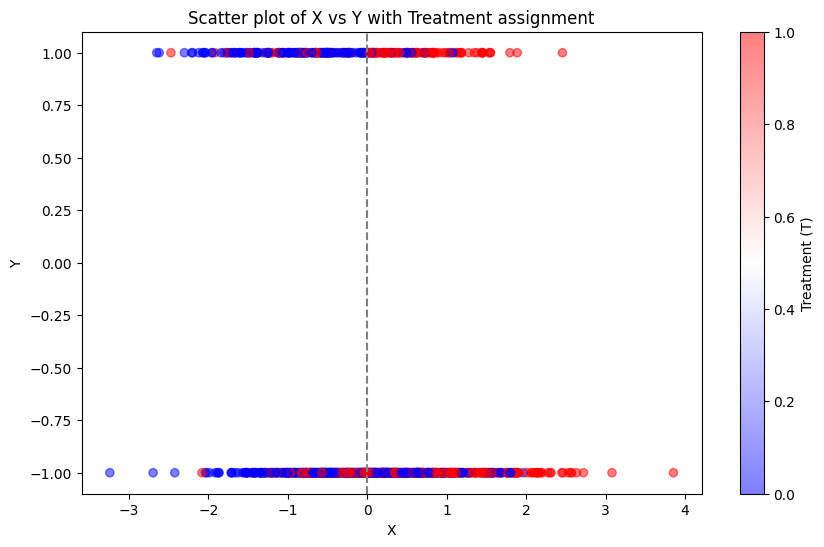

In [11]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plot for X vs Y with color based on Treatment (T)
plt.scatter(data_observed["X"], data_observed["Y"], c=data_observed["T"], cmap='bwr', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at x = 0
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot of X vs Y with Treatment assignment")
plt.colorbar(label='Treatment (T)')
plt.show()


In [12]:
# Save the observed data to a CSV file
data_observed.to_csv("data_observed.csv", index=False)

# Save the full data to a CSV file
data_full.to_csv("data_full.csv", index=False)
